In [467]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from python.analysis import Plots
from python.analysis.shower_merging import SetPlotStyle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp

from rich import print

SetPlotStyle()

def Hist2DComparison(x, y, x_range, y_range, x_labels = None, y_labels = None, titles = None, bins = 50, cmap = "plasma", func = None, orientation = "horizontal"):
    if x_labels is None: x_labels = [""]*len(x)
    if y_labels is None: y_labels = [""]*len(y)
    if titles is None: titles = [""] * len(x)

    dim = figure_dimensions(len(x), orientation)
    fig_size = (6.4 * dim[1], 4.8 * dim[0])
    ranges = [x_range, y_range]

    vmax = 0
    for xs, ys in zip(x, y):
        h, _, _ = np.histogram2d(xs, ys, bins, range = ranges)
        vmax = max(vmax, np.max(h))

    fig = plt.figure(figsize = fig_size)
    for i in range(len(x)):
        plt.subplot(*dim, i + 1)
        if func is None:
            _, _, _, im = plt.hist2d(x[i], y[i], bins, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        else:
            _, _, _, im = func(x = x[i], y = y[i], bins = bins, ranges = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.title(titles[i])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, cax = cbar_ax)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5")
print(df)

reco_energy  true_energy
0       133.802572   268.863259
1       127.616533  1343.636619
2       104.872036   129.958027
3        75.675744    89.715949
4       563.250869   770.033836
...            ...          ...
16581   545.426464   531.016507
16582   516.226603   335.723310
16583   565.426627   385.056909
16584    35.134860    90.807447
16585   246.498951   420.794547

[16586 rows x 2 columns]

# Linear Correction

[   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000.]

reco_energy  true_energy
0       133.802572   268.863259
1       127.616533  1343.636619
2       104.872036   129.958027
3        75.675744    89.715949
4       563.250869   770.033836
...            ...          ...
16383   545.426464   531.016507
16384   516.226603   335.723310
16385   565.426627   385.056909
16386    35.134860    90.807447
16387   246.498951   420.794547

[16388 rows x 2 columns]

[0.85287011] [[0.02743517]]

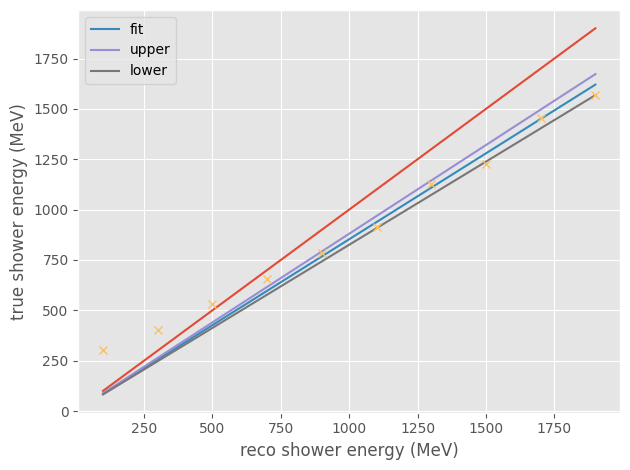

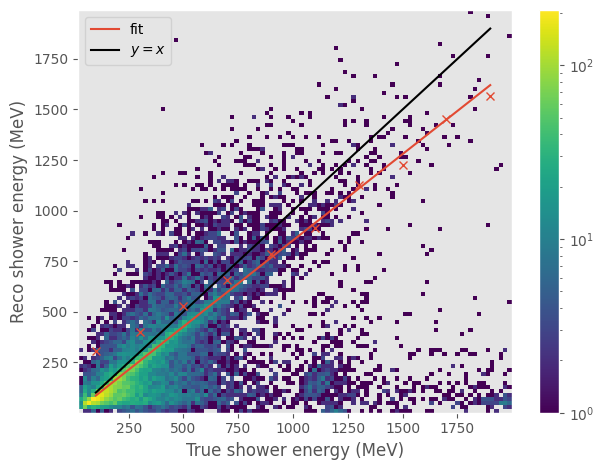

In [3]:
def lineI(x, m):
    return m * x

bins = np.linspace(0, 2000, 11)
print(bins)
print(df)


binned_data = []
for i in range(1, len(bins)):
    data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
    binned_data.append(data[data.true_energy < 2000])


x = (bins[1:] + bins[:-1]) / 2

y = np.array([d.true_energy.mean() for d in binned_data])

popt, pcov = curve_fit(lineI, x, y)

print(popt, pcov**0.5)

err = np.array([pcov[i][i] for i in range(len(popt))])**0.5

Plots.Plot(x, x)
Plots.Plot(x, lineI(x, *popt), newFigure = False, label = "fit")
Plots.Plot(x, lineI(x, *(popt + err)), newFigure = False, label = "upper")
Plots.Plot(x, lineI(x, *(popt - err)), newFigure = False, label = "lower")

Plots.Plot(x, y, marker = "x", linestyle = "", xlabel = "reco shower energy (MeV)", ylabel = "true shower energy (MeV)", newFigure = False)

Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 2000], y_range = [0, 2000])
Plots.Plot(x, lineI(x, *popt), newFigure = False, label = "fit", color = "C0")
Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
Plots.Plot(x, y, marker = "x", linestyle = "", xlabel = "True shower energy (MeV)", ylabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")

correction factor : 0.8528701062421319

mean shower energy fractional error: -0.21781160487353243 +- 0.5460151496829554

mean shower energy fractional error after correction: -0.08287511849500513 +- 0.6402090373278253

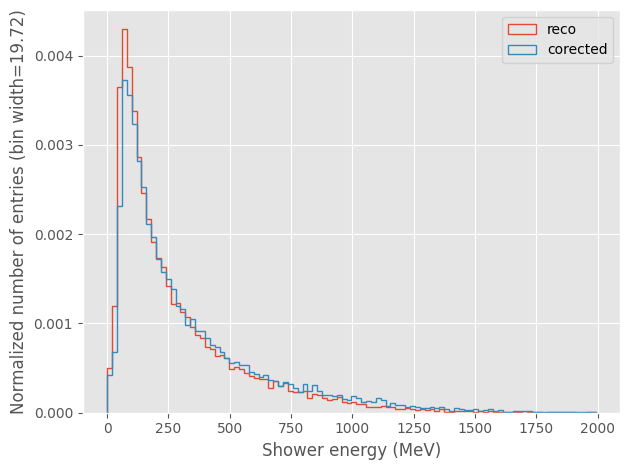

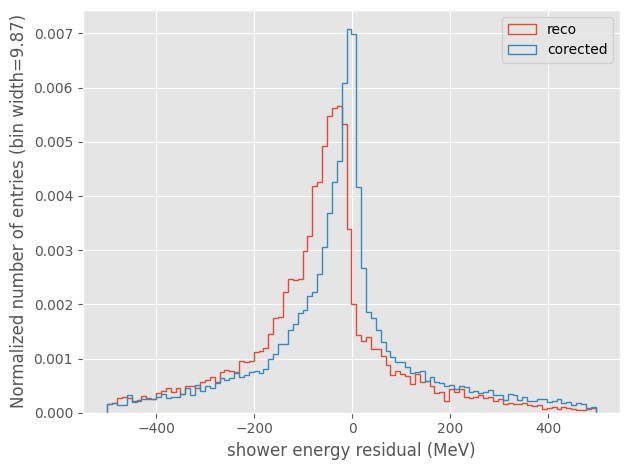

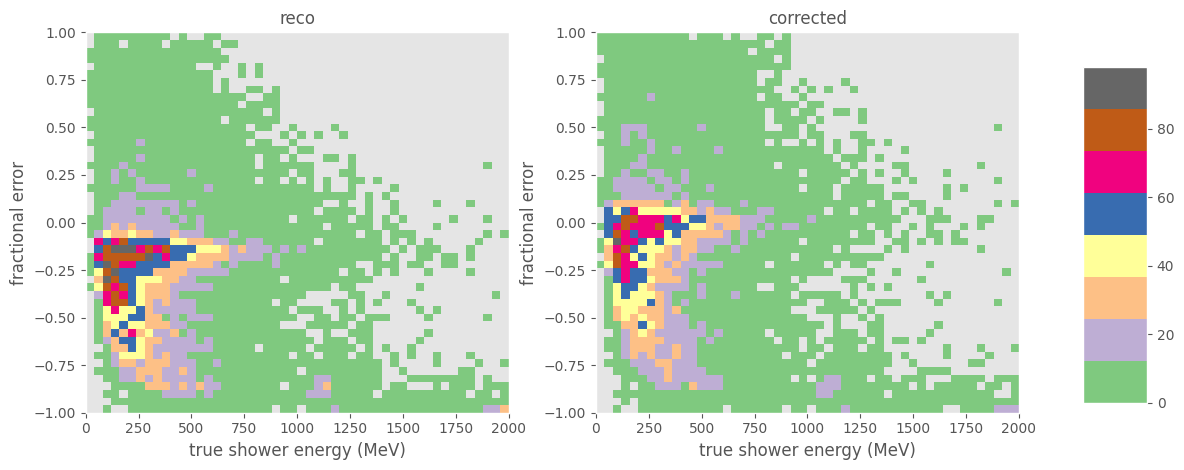

In [4]:

def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim

# corrected_energy = lineI(df.reco_energy, *popt)
corrected_energy = df.reco_energy / popt[0]

fe = (df.reco_energy / df.true_energy) - 1
fec = (corrected_energy / df.true_energy) - 1

print(f"correction factor : {popt[0]}")
print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["reco", "corected"], xRange = [0, 2000], xlabel = "Shower energy (MeV)")
Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["reco", "corected"], xRange=[-500, 500], xlabel = "shower energy residual (MeV)")

Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["true shower energy (MeV)"]*2, y_labels = ["fractional error"]*2, titles = ["reco", "corrected"])

# Parameterised correction

In [393]:
from scipy.special import gamma, erf

def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim


class student_t:
    n_params = 4
    
    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A, mu, nu, l):
        t = (x - mu)/ l
        return (A**2 / l) * (gamma((nu + 1)/2) / (np.sqrt(nu * np.pi) * gamma(nu/2))) * (1 + t**2/nu)**(-(nu + 1)/2)

    @staticmethod
    def bounds():
        return [(0, -np.inf, 0.01, -np.inf),
                (np.inf, np.inf, 10, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), 2, np.std(x)]

    @staticmethod
    def mu(A, mu, nu, l):
        return mu


class double_gaussian:
    n_params = 6

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        return A_1 * np.exp(-(x - mu_1)**2 / (2 * sigma_1**2)) + A_2 * np.exp(-(x - mu_2)**2 / (2 * sigma_2**2))

    @staticmethod
    def bounds():
        return [(0, -np.inf, 0.001, 0, -np.inf, 0.001),
                (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.mean(x), np.std(x), max(y), np.mean(x), np.std(x)]

    @staticmethod
    def mu(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)
        return w_1 * mu_1 + w_2 * mu_2

class crystal_ball:
    n_params = 5

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, S, mu, sigma, alpha, n):
        t = (x - mu) / sigma

        a_alpha = abs(alpha)
        n_alpha = n / a_alpha

        A = (n_alpha)**n * np.exp(-a_alpha**2 / 2)

        B = n_alpha - a_alpha

        C = (n_alpha) * (1/(n - 1)) * np.exp(-a_alpha**2/2)

        D = np.sqrt(np.pi / 2) *(1 + erf(a_alpha/np.sqrt(2)))

        N = 1 / (C + D) # should be 1 / sigma * (C + D), but I dont want to normalise the function

        y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)
        return S * N * y

    @staticmethod
    def bounds():
        return [(0, -np.inf, -np.inf, 1, 2),
                (np.inf, np.inf, np.inf, 3, 10)]

    @staticmethod
    def p0(x,y):
        return [max(y), np.mean(x), np.std(x), 1, 2]

    @staticmethod
    def mu(S, mu, sigma, alpha, n):
        return mu

def reduced_chi_squared(y_true, y_pred, n_params):
    residuals = y_true - y_pred
    chi_squared = np.sum(residuals**2) / np.var(y_true)
    degrees_of_freedom = len(y_true) - n_params
    reduced_chi_squared = chi_squared / degrees_of_freedom
    return reduced_chi_squared

def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [4]:
def count_bins(bins : list):
    counts = []
    for i in range(1, len(bins)):
        mask = (df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])
        counts.append(np.sum(mask))
    return np.array(counts)


def recompute_bins(initial_bins : list, fraction : np.array, step : float) -> list:
    new_bins = []
    for i in range(1, len(initial_bins)-1):
        if fraction[i - 1] > fraction[i]:
            new_bins.append(initial_bins[i] - step)
        elif fraction[i - 1] < fraction[i]:
            new_bins.append(initial_bins[i] + step)
        else:
            new_bins.append(initial_bins[i])

    new_bins.insert(0, initial_bins[0])
    new_bins.append(initial_bins[-1])
    return new_bins


def optimise_bins(data : np.array, initial_bins : list, tolerence : float = 0.01, step : float = 1):
    optimised_bins = initial_bins
    maximum = 1 / (len(optimised_bins) - 1)
    n_entries = len(data[(data > min(initial_bins)) & (data < max(initial_bins))])
    even_counts = False
    while not even_counts:
        counts = count_bins(optimised_bins)
        fraction = counts / n_entries

        even_counts = all(abs(fraction - maximum) < tolerence)

        optimised_bins = recompute_bins(optimised_bins, fraction, step)
    print(fraction)
    return optimised_bins

In [492]:
def fit_regions(funcs, reco_bins : list, hist_bins : int, log : bool = False):
    def print_log(x):
        if log: print(x)
    
    dim = figure_dimensions(len(reco_bins) - 1)
    plt.subplots(*dim, figsize = (6.4 * dim[1], 4.8 * dim[0]))

    means = []
    for i in range(1, len(bins)):
        print_log(i)
        binned_data = df[(df.reco_energy > bins[i-1]) & (df.reco_energy < bins[i])]
        plt.subplot(*dim, i)

        # fractional_error = (binned_data.reco_energy /binned_data.true_energy) - 1

        y, edges = np.histogram(binned_data.true_energy, bins = hist_bins, range = [min(reco_bins), max(reco_bins)])
        x = (edges[1:] + edges[:-1]) / 2

        best_f = None
        best_popt = None
        best_perr = None
        k_best = None
        p_best = None

        for f in funcs:
            function = f()
            popt = None
            pcov = None
            perr = None
            try:
                popt, pcov = curve_fit(function.func, x, y, p0 = function.p0(x, y), method = "dogbox", bounds = function.bounds())
                perr = np.sqrt(np.diag(pcov))
                print_log(popt)
                print_log(perr)
                print_log(pcov)
            except:
                print_log("could not fit")
                pass
            y_pred = function.func(x, *popt) if popt is not None else None
            if y_pred is not None:
                k, p = ks_2samp(y, y_pred)
            else:
                k = 1
                p = 0

            if p_best is None or p > p_best : # lerger p value suggests a better fit
                p_best = p
                k_best = k
                best_popt = popt
                best_perr = perr
                best_f = f

        mean = None
        # Plots.Plot(x, y, marker = "x", newFigure = False)
        if best_popt is not None:
            function = best_f()
            mean = function.mu(*best_popt)
            y_pred = function.func(x, *best_popt)
            k, p = ks_2samp(y, y_pred)

            # r_sqr = r_squared(y, y_pred)
            # chi_sqr = reduced_chi_squared(y, y_pred, function.n_params)
            Plots.Plot(x, y_pred, marker = "x", color = "black", newFigure = False)
            plt.axvline(mean, color = "black", linestyle = "--")
        Plots.PlotHist(binned_data.true_energy, bins = hist_bins, newFigure = False, xlabel = f"{[reco_bins[i-1], reco_bins[i]]}", range = [min(reco_bins), max(reco_bins)])

        if best_popt is not None:
            text = ""
            for j in range(len(best_popt)):
                text += f"\np{j}: ${best_popt[j]:.2f}\pm${best_perr[j]:.2f}"
            # text += f"\n$r^{2}$: {r_sqr:.2f}"
            # text += f"\nreduced $\chi^{2}$: {chi_sqr:.2f}"
            text += f"\nks : {k_best:.2f}, p : {p_best:.2f}"
            legend = plt.legend(handlelength = 0, labels = [text[1:]], title = best_f.__name__.replace("_", " "))
            for l in legend.legendHandles:
                l.set_visible(False)
        means.append(mean)
    return means

/tmp/ipykernel_14509/442767043.py:91: RuntimeWarning: invalid value encountered in power
  y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)


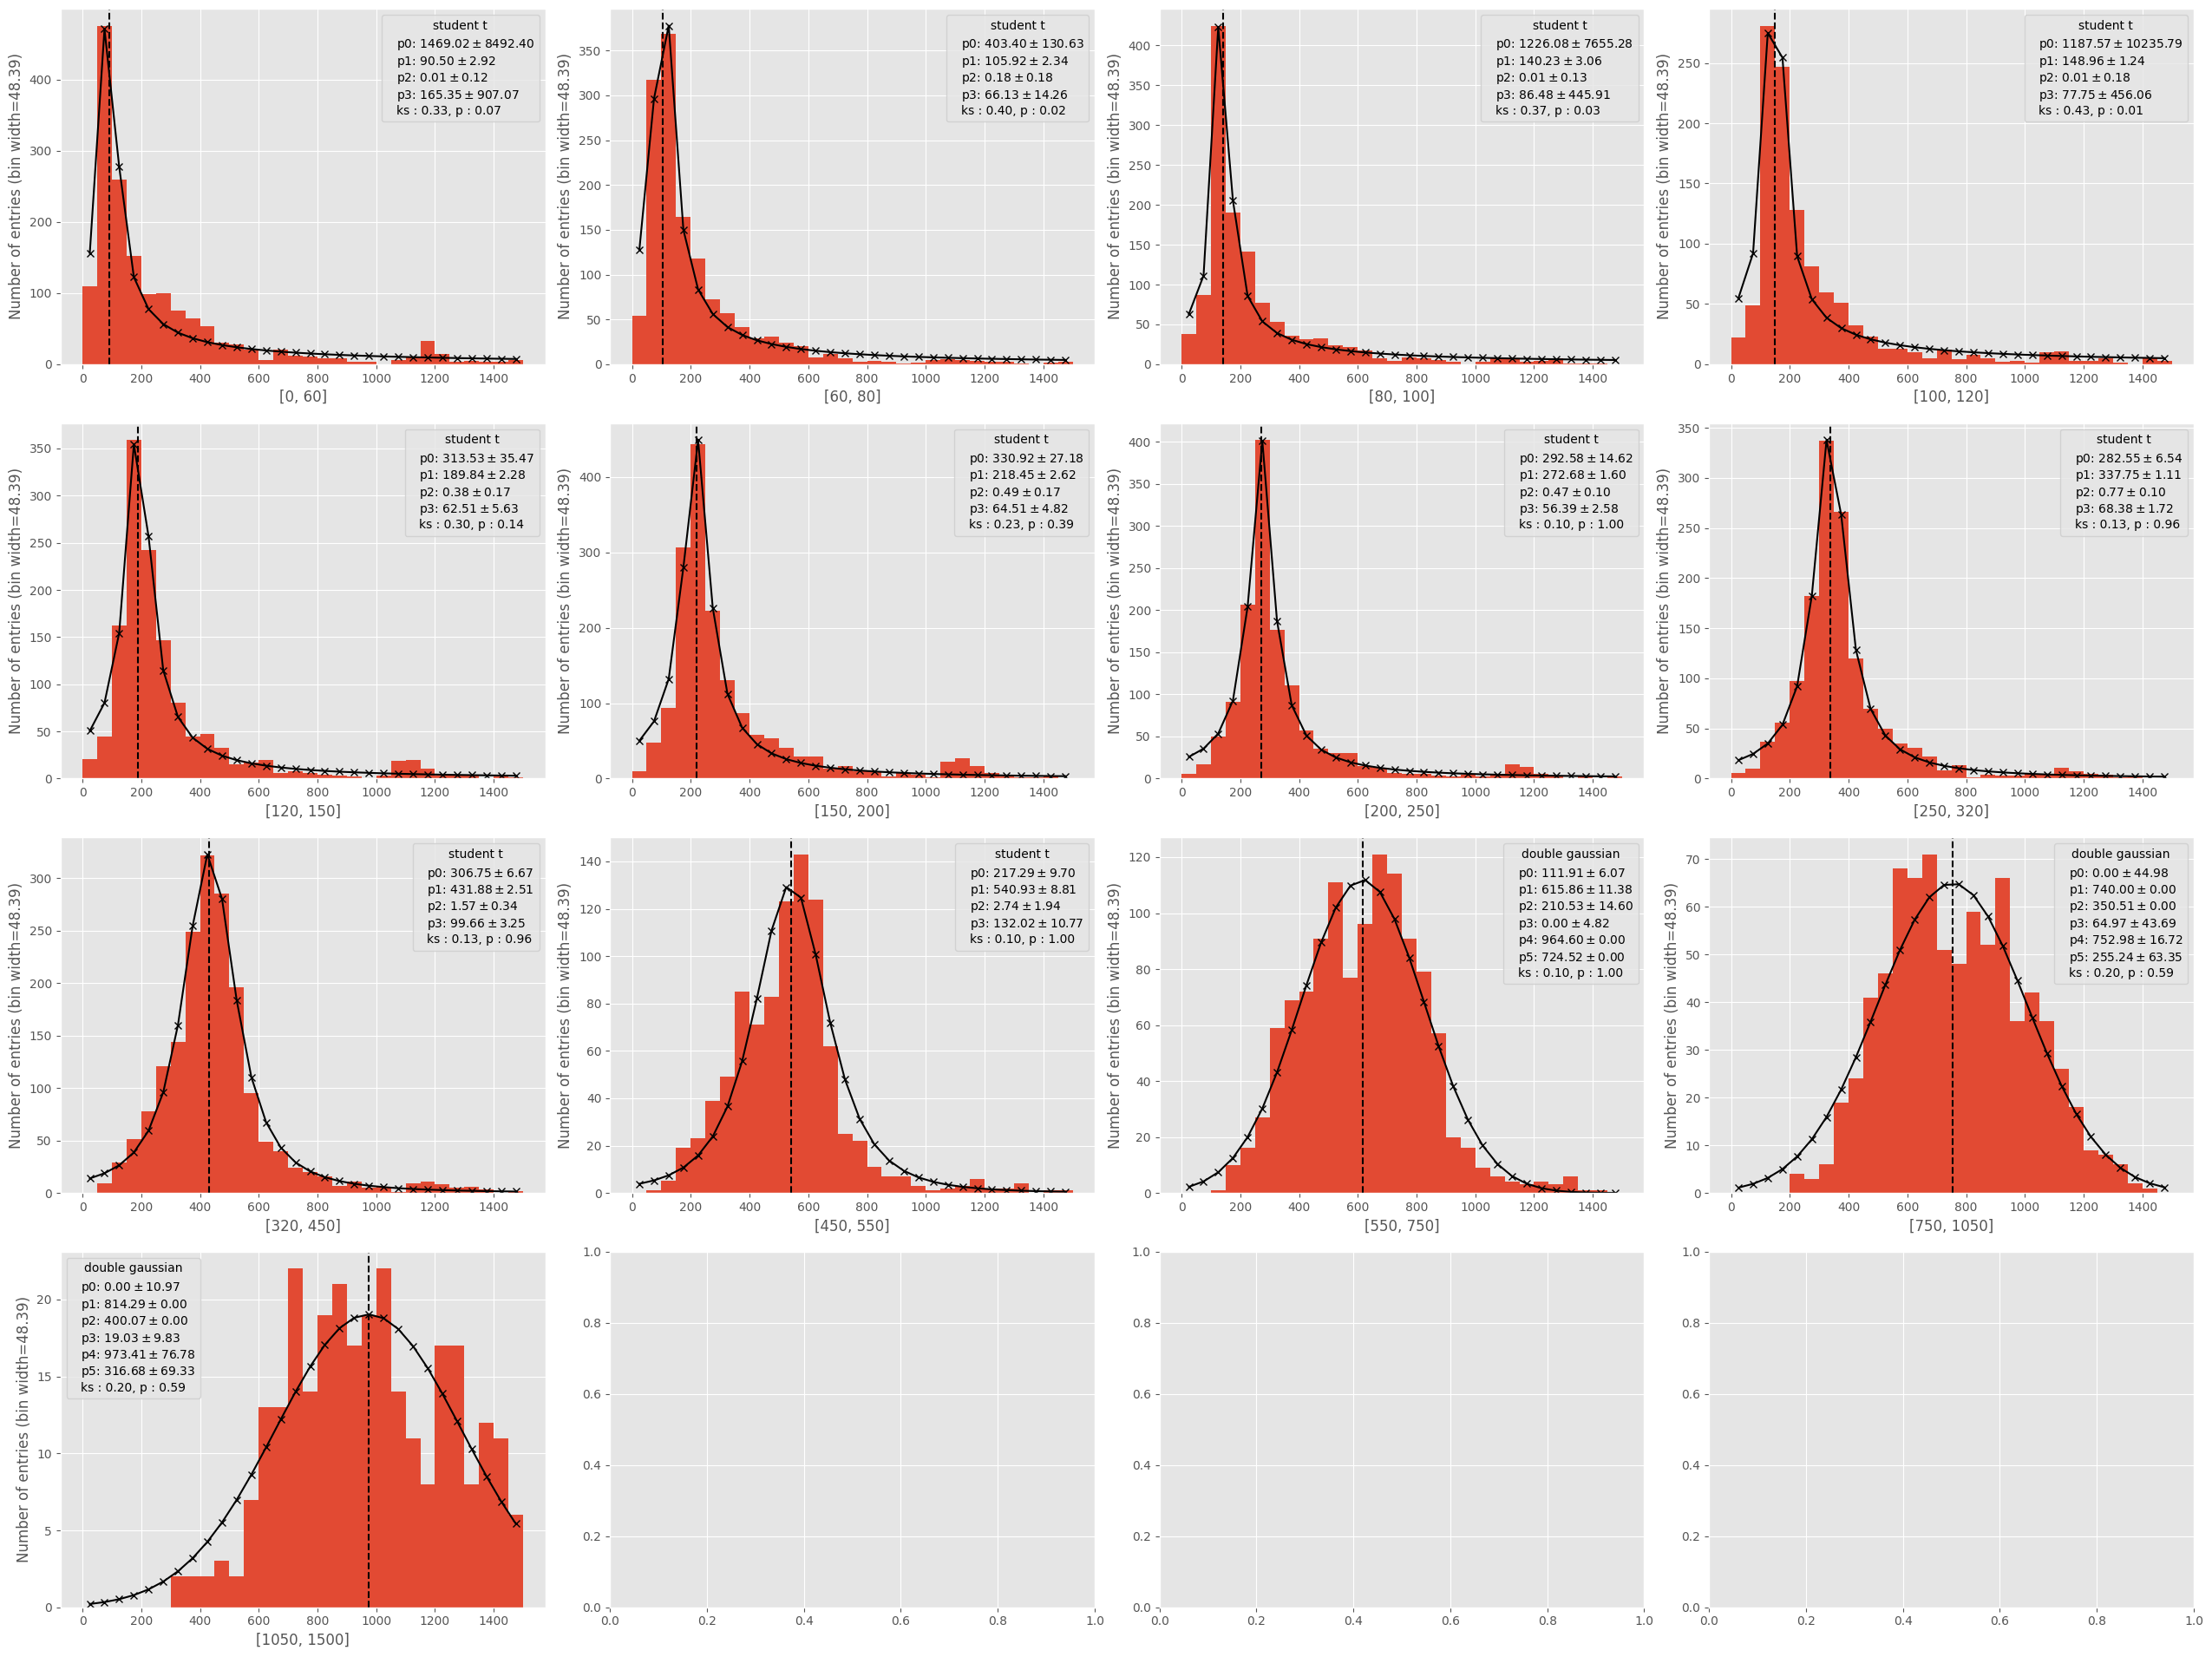

In [540]:
# bins = optimise_bins(df.reco_energy, [0, 100, 250, 2000], 0.001)
bins = np.array([0, 60, 80, 100, 120, 150, 200, 250, 320, 450, 550, 750, 1050, 1500])
# for f in [student_t, double_gaussian, crystal_ball]:
means = fit_regions([double_gaussian, crystal_ball, student_t], bins, 30)

## polynomial parameterisation

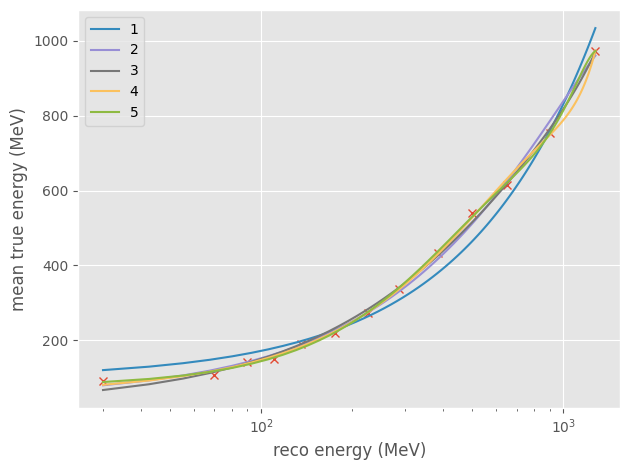

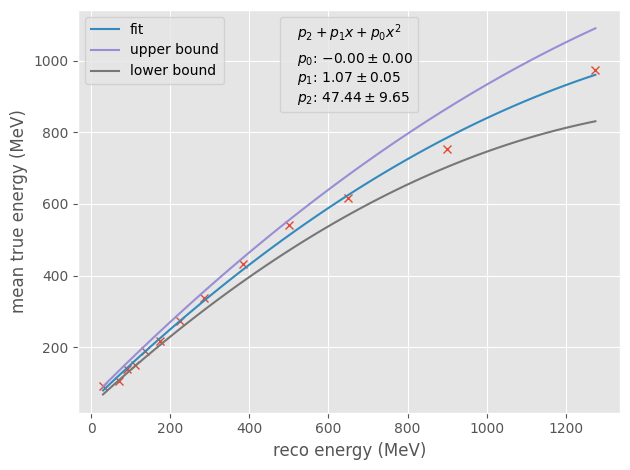

In [541]:
x = (bins[1:] + bins[:-1]) / 2
x_interp = np.linspace(min(x), max(x), 100)
Plots.Plot(x, means, marker = "x", linestyle = "", xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)")

for o in range(1, 6):
    polyfit = np.polyfit(x, means, o)
    Plots.Plot(x_interp, np.polyval(polyfit, x_interp), xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)", newFigure = False, x_scale = "log", label = o)


popt, pcov = np.polyfit(x, means, 2, cov = True)
perr = np.sqrt(np.diag(pcov))
Plots.Plot(x, means, marker = "x", linestyle = "", xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)")
Plots.Plot(x_interp, np.polyval(popt, x_interp), xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)", newFigure = False, x_scale = "log", label = "fit")
Plots.Plot(x_interp, np.polyval(popt+perr, x_interp), xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)", newFigure = False, x_scale = "log", label = "upper bound")
Plots.Plot(x_interp, np.polyval(popt-perr, x_interp), xlabel = "reco energy (MeV)", ylabel = "mean true energy (MeV)", newFigure = False, x_scale = "linear", label = "lower bound")

text = ""
for j in range(len(popt)):
    text += f"\n$p_{j}$: ${popt[j]:.2f}\pm${perr[j]:.2f}"
legend = plt.legend(handlelength = 0, labels = [text[1:]], title = "$p_{2} + p_{1}x + p_{0}x^{2}$", loc = "upper center")
for l in legend.legendHandles:
    l.set_visible(False)
plt.gca().add_artist(legend)
plt.legend()

mean shower energy fractional error: -0.21828763609496118 +- 0.5481459601279287

mean shower energy fractional error after correction: -0.03447259639322717 +- 0.629924900317929

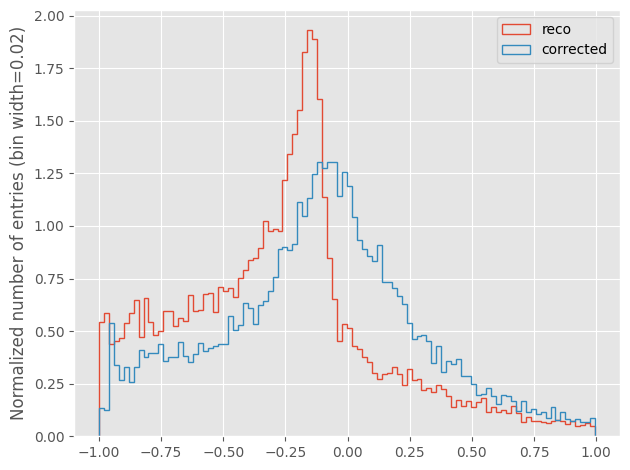

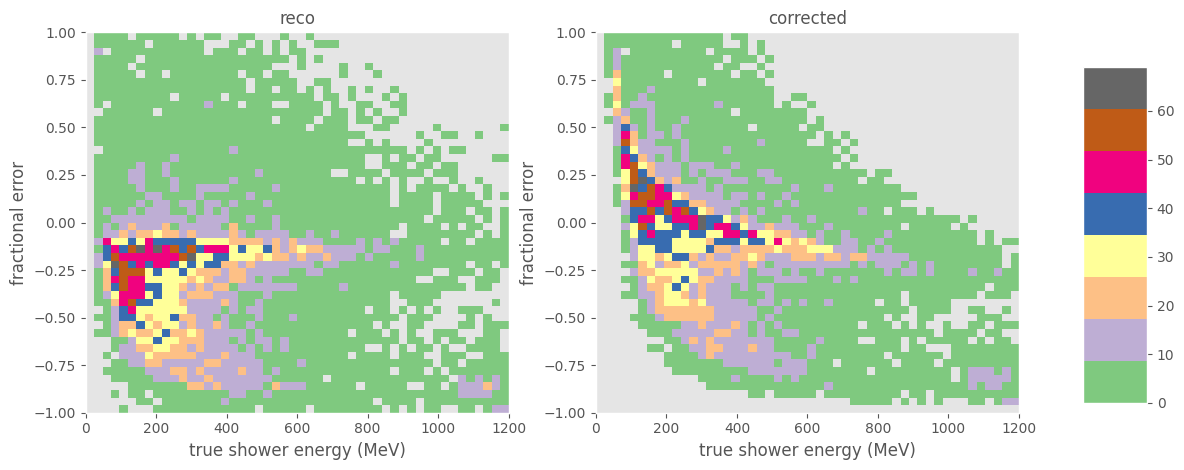

In [542]:
corrected_energy = np.polyval(popt, df.reco_energy)

fe = (df.reco_energy / df.true_energy) - 1
fec = (corrected_energy / df.true_energy) - 1

Plots.PlotHistComparison([fe, fec], labels = ["reco", "corrected"], xRange = [-1, 1])
Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 1200], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["true shower energy (MeV)"]*2, y_labels = ["fractional error"]*2, titles = ["reco", "corrected"])

print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")


## power law paramaterisation

[  0.68725232   7.31457269 -17.93232646]

[ 0.04600114  2.51753439 26.23603528]

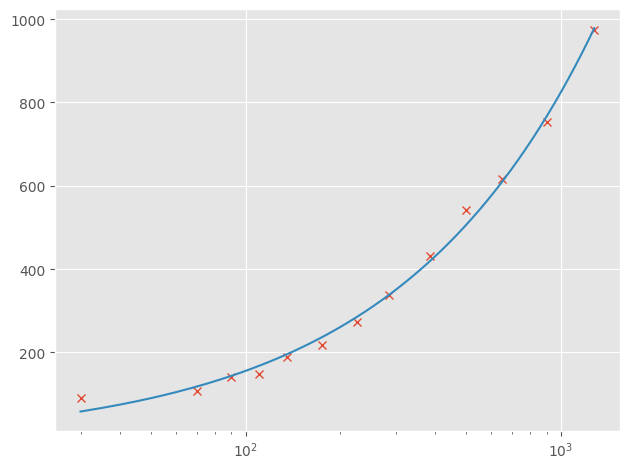

In [569]:
def power_law(x, a, b, c):
    return b*(x**a) + c


x = (bins[1:] + bins[:-1]) / 2
x_interp = np.linspace(min(x), max(x), 500)

popt, pcov = curve_fit(power_law, x, means)

perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr)

Plots.Plot(x, means, marker = "x", linestyle = "")
Plots.Plot(x_interp, power_law(x_interp, *popt), newFigure = False, x_scale = "log")


mean shower energy fractional error: -0.21828763609496118 +- 0.5481459601279287

mean shower energy fractional error after correction: -0.04274693887684165 +- 0.6162421199377444

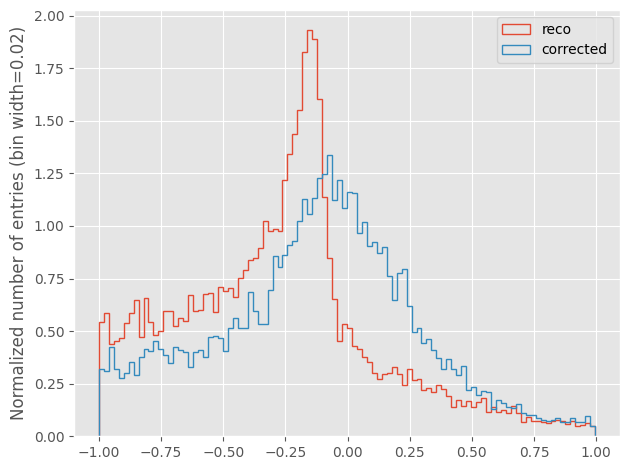

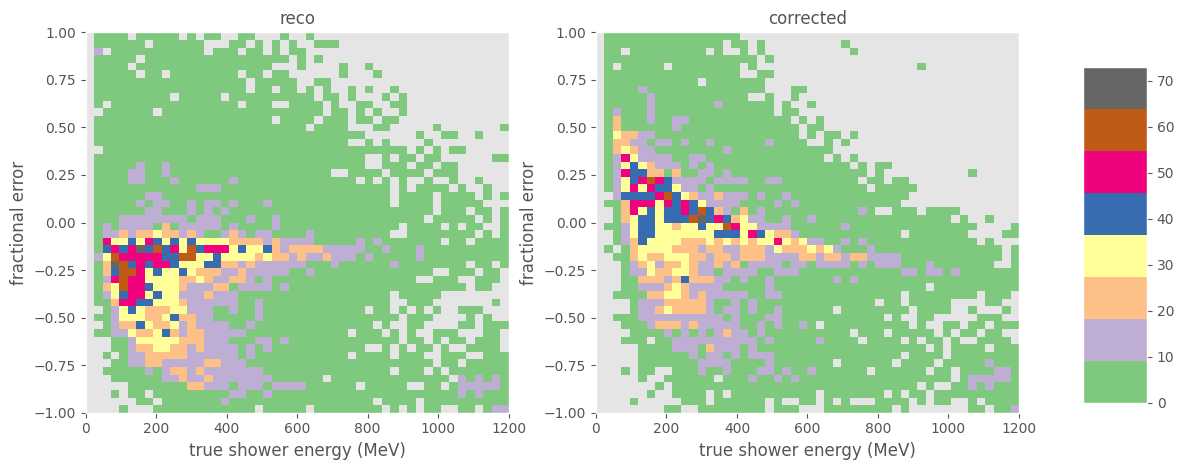

In [568]:
corrected_energy = power_law(df.reco_energy, *popt)

fe = (df.reco_energy / df.true_energy) - 1
fec = (corrected_energy / df.true_energy) - 1

Plots.PlotHistComparison([fe, fec], labels = ["reco", "corrected"], xRange = [-1, 1])
Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 1200], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["true shower energy (MeV)"]*2, y_labels = ["fractional error"]*2, titles = ["reco", "corrected"])

print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")